In [757]:
import pandas as pd
import numpy as np
import warnings

warnings.filterwarnings("ignore")

In [758]:
model_train = 'yolo'
model_infer = 'resnet'
 
model_train = 'resnet'
model_infer = 'mobnet'
 
model_train = 'mobnet'
model_infer = 'lstm'
 
model_train = 'mobnet'
model_infer = 'mobnet'
 
model_train = 'resnet'
model_infer = 'bert'

# arr_rate = 60
# arr_rate_list, from 30 to 120 in 5 increments

# time_list, from 0.5 to 2 in 0.1 increments

arr_rate_list = [30, 40, 50, 60, 70, 80, 90, 100, 110, 120]
time_list = [0.5, 0.6, 0.7, 0.8, 0.9, 1.0, 1.1, 1.2, 1.3, 1.4, 1.5, 1.6, 1.7, 1.8, 1.9, 2.0]
power_list = np.arange(10, 51, 1)

if model_infer == 'bert' or model_train == 'bert':

    time_list = [2, 2.5, 3, 3.5, 4, 4.5, 5, 5.5, 6]
    arr_rate_list = [1,2,3,4,5,6,7,8,9,10, 11, 12, 13, 14, 15]
    power_list = np.arange(10, 61, 1)
    print(len(arr_rate_list)*len(time_list)*len(power_list))

6885


In [759]:
data_train = pd.read_csv(f'{model_train}_train_data_final.csv')
data_infer = pd.read_csv(f'{model_infer}_infer_data_final.csv')

In [760]:
core_vals=[4, 8, 12] #3 possible values
gpu_vals=[114750000, 318750000, 522750000, 726750000, 930750000, 1134750000, 1300500000]
cpu_vals=[422400, 729600, 1036800, 1344000, 1651200, 1958400, 2201600] #in kHz, 7 possible values
mem_vals = [665600000, 2133000000, 3199000000]
bs_vals = [1, 4, 16, 32, 64]

In [761]:
# # Filter data based on values in the list only
data_train = data_train[data_train['cores'].isin(core_vals)]
data_train = data_train[data_train['gpu'].isin(gpu_vals)]
data_train = data_train[data_train['cpu'].isin(cpu_vals)]
data_train = data_train[data_train['mem'].isin(mem_vals)]
data_train.reset_index(drop=True, inplace=True)

In [762]:
def return_initial_samples(data, power_budget):
    mid_cores = int(np.median(core_vals))
    mid_gpu = int(np.median(gpu_vals))
    mid_cpu = int(np.median(cpu_vals))
    mid_mem = int(np.median(mem_vals))

    index_list = []

    # Extarct the sample with mid values
    mid_sample = data[(data['cores'] == mid_cores) & (data['gpu'] == mid_gpu) & (data['cpu'] == mid_cpu) & (data['mem'] == mid_mem)]
    # Extract the index of the sample
    mid_index = mid_sample.index[0]
    index_list.append(mid_index)
    mid_power = mid_sample['interleaved_power'].values[0]

    if mid_power > power_budget:
        new_cores = int(min(core_vals))
        new_gpu = int(min(gpu_vals))
        new_cpu = int(min(cpu_vals))
        new_mem = int(min(mem_vals))

        sample1 = data[(data['cores'] == new_cores) & (data['gpu'] == mid_gpu) & (data['cpu'] == mid_cpu) & (data['mem'] == mid_mem)]
        sample2 = data[(data['cores'] == mid_cores) & (data['gpu'] == new_gpu) & (data['cpu'] == mid_cpu) & (data['mem'] == mid_mem)]
        sample3 = data[(data['cores'] == mid_cores) & (data['gpu'] == mid_gpu) & (data['cpu'] == new_cpu) & (data['mem'] == mid_mem)]
        sample4 = data[(data['cores'] == mid_cores) & (data['gpu'] == mid_gpu) & (data['cpu'] == mid_cpu) & (data['mem'] == new_mem)]

        index_list.append(sample1.index[0])
        index_list.append(sample2.index[0])
        index_list.append(sample3.index[0])
        index_list.append(sample4.index[0])

        pair1 = index_list[0:2]
        pair2 = index_list[0:1] + index_list[2:3]
        pair3 = index_list[0:1] + index_list[3:4]
        pair4 = index_list[0:1] + index_list[4:5]

        pairs = [pair1, pair2, pair3, pair4]
    
    else:
        new_cores = int(max(core_vals))
        new_gpu = int(max(gpu_vals))
        new_cpu = int(max(cpu_vals))
        new_mem = int(max(mem_vals))

        sample1 = data[(data['cores'] == new_cores) & (data['gpu'] == mid_gpu) & (data['cpu'] == mid_cpu) & (data['mem'] == mid_mem)]
        sample2 = data[(data['cores'] == mid_cores) & (data['gpu'] == new_gpu) & (data['cpu'] == mid_cpu) & (data['mem'] == mid_mem)]
        sample3 = data[(data['cores'] == mid_cores) & (data['gpu'] == mid_gpu) & (data['cpu'] == new_cpu) & (data['mem'] == mid_mem)]
        sample4 = data[(data['cores'] == mid_cores) & (data['gpu'] == mid_gpu) & (data['cpu'] == mid_cpu) & (data['mem'] == new_mem)]

        index_list.append(sample1.index[0])
        index_list.append(sample2.index[0])
        index_list.append(sample3.index[0])
        index_list.append(sample4.index[0])

        pair1 = index_list[0:2]
        pair2 = index_list[0:1] + index_list[2:3]
        pair3 = index_list[0:1] + index_list[3:4]
        pair4 = index_list[0:1] + index_list[4:5]

        pairs = [pair1, pair2, pair3, pair4]

    return pairs

In [763]:
def fit_lines(data, pairs, zero_list, dom):

    # if dom == 'train':
    #     print("Train Slope Calculation")
    # else:
    #     print("Infer Slope Calculation")

    flag = False
    mode = ['cores', 'gpu','cpu','mem']
    slopes = []

    
    for i in range(len(pairs)):
        # Fit a time and power line for each pair
        sample1 = data.iloc[pairs[i][0]]
        sample2 = data.iloc[pairs[i][1]]
        
        sample1['cores'] = sample1['cores']*100
        sample1['cpu'] = sample1['cpu']/1000
        sample1['mem'] = sample1['mem']/1000000
        sample1['gpu'] = sample1['gpu']/1000000

        sample2['cores'] = sample2['cores']*100
        sample2['cpu'] = sample2['cpu']/1000
        sample2['mem'] = sample2['mem']/1000000
        sample2['gpu'] = sample2['gpu']/1000000
        # print(sample1)
        # print(sample2)

        x1 = sample1[mode[i]]
        x2 = sample2[mode[i]]

        if dom == 'train':
            yt1 = sample1['observed_time_train']
            yt2 = sample2['observed_time_train']

            yp1 = sample1['observed_power_train']
            yp2 = sample2['observed_power_train']

        else:
            yt1 = sample1['observed_time_infer']
            yt2 = sample2['observed_time_infer']

            yp1 = sample1['observed_power_infer']
            yp2 = sample2['observed_power_infer']
        
        m_time = (yt2 - yt1)/(x2 - x1)
        # c_time = yt1 - m_time*x1

        m_power = (yp2 - yp1)/(x2 - x1)
        # c_power = yp1 - m_power*x1

        slope = m_time/m_power

        if abs(yp2 - yp1) < 1:
            slope = 0
            # print("Power under 1W for mode {dim}, setting slope to 0".format(dim=mode[i]))
        # print("Mode : ", mode[i])
        # m_time_formated = "{:.3f}".format(m_time)
        # c_time_formated = "{:.3f}".format(c_time)
        # m_power_formated = "{:.3f}".format(m_power)
        # c_power_formated = "{:.3f}".format(c_power)
        # print(f"Time Line: y = {m_time_formated}x + {c_time_formated}")
        # print(f"Power Line: y = {m_power_formated}x + {c_power_formated}")
        # print("B/A =","{:.3f}".format( m_time/m_power))
        slopes.append(slope)
        # print("\n")
    

    slopes = [abs(x) for x in slopes]
    # change any value greater than 100 to 0 in slopes list

    zero_index = [mode.index(x) for x in zero_list]

    for i in zero_index:
        slopes[i] = 0

    # round the slopes to 2 decimal places
    slopes_print = [round(x, 2) for x in slopes]
    # print("Slopes (Cores, GPU, CPU, Memory): ", slopes_print)
    if sum(slopes) == 0:
        flag = True
    # return the index of the minimum value in the slopes list
    max_index = slopes.index(max(slopes))
    max_dim = mode[max_index]
    
    return max_index, max_dim, flag


In [764]:
def bin_search(core_vals, cpu_vals, gpu_vals, mem_vals, dim, step, cores, cpu, gpu, mem):
    # Using binary search to find the optimal value for the dimension

    
    if dim == 'cores':
        vals = core_vals
        value = cores
    elif dim == 'cpu':
        vals = cpu_vals
        value = cpu
    elif dim == 'gpu':
        vals = gpu_vals
        value = gpu
    else:
        vals = mem_vals
        value = mem

    if step=='next':    
        # print("Mode: Next")
        dim_index = vals.index(value)
        # print("Dim Index: ", dim_index)
        last_index = len(vals)-1
        # print("Last Index: ", last_index)
        new_index = int(np.ceil((dim_index + last_index)/2))
        value = vals[new_index]
        vals = vals[dim_index+1:]


    else:
        # print("Mode: Prev")
        dim_index = vals.index(value)
        new_index = int(np.floor(dim_index/2))
        value = vals[new_index]
        vals = vals[:dim_index]

    return value, vals


In [765]:
def main(data_train, data_infer, power_budget, max_count, start_bs):

    index_list = []

    zero_list = []

    visited_dim = []

    core_vals=[4, 8, 12] #3 possible values
    gpu_vals=[114750000, 318750000, 522750000, 726750000, 930750000, 1134750000, 1300500000]
    cpu_vals=[422400, 729600, 1036800, 1344000, 1651200, 1958400, 2201600] #in kHz, 7 possible values
    mem_vals = [665600000, 2133000000, 3199000000]
    bs_vals = [1, 4, 16, 32, 64]

    data_infer = data_infer[data_infer['bs'] == start_bs]
    data_infer.reset_index(drop=True, inplace=True)
    data_train.reset_index(drop=True, inplace=True)
    # merge the data_train and data_infer based on cores, gpu, cpu, mem with suffixes _train and _infer
    data = pd.merge(data_train, data_infer, on=['cores', 'gpu', 'cpu', 'mem'], suffixes=('_train', '_infer'))
    data['interleaved_power'] = np.maximum(data['observed_power_train'], data['observed_power_infer'])
    data['interleaved_time'] = data['observed_time_train'] + data['observed_time_infer']
    
    pairs = return_initial_samples(data, power_budget)

    for i in pairs:
        index_list.append(i[0])
        index_list.append(i[1])

    # print("Initial Pairs: ", pairs)

    mid_index = index_list[0]

    # # print("Initial Index: ", mid_index)
    mid_power_train = data.iloc[mid_index]['observed_power_train']
    mid_power_infer = data.iloc[mid_index]['observed_power_infer']

    curr_power_train = mid_power_train
    curr_power_infer = mid_power_infer

    # print("Initial Train Power: ", mid_power_train)
    # print("Initial Infer Power: ", mid_power_infer)
    # print("\n")

    count = 1
    while count < max_count:

        if curr_power_train > curr_power_infer:
            max_index, max_dim, flag = fit_lines(data, pairs, zero_list, 'train')
        else:
            max_index, max_dim, flag = fit_lines(data, pairs, zero_list, 'infer')
        
        # print("Dimension with max slope: ", max_dim)
        visited_dim.append(max_dim)

        if flag:
            break

        next_pair = pairs[max_index]

        if count == 1:
            curr_sample = data.iloc[next_pair[0]]
            curr_cores = curr_sample['cores']
            curr_cpu = curr_sample['cpu']
            curr_gpu = curr_sample['gpu']
            curr_mem = curr_sample['mem']
            curr_power_train = curr_sample['observed_power_train']
            curr_power_infer = curr_sample['observed_power_infer']
            
        interleaved_power = np.maximum(curr_power_train, curr_power_infer)



        if interleaved_power < power_budget:
            value, vals = bin_search(core_vals, cpu_vals, gpu_vals, mem_vals, max_dim, 'next', curr_cores, curr_cpu, curr_gpu, curr_mem)
            # print("New Dim value: ", value)
            # print("Updated dim list: ", vals)
            if len(vals) == 1:
                zero_list.append(max_dim)
                # print("Setting slope of {dim} to 0".format(dim=max_dim))

            if max_dim == 'cores':
                curr_cores = value
                core_vals = vals
            elif max_dim == 'cpu':
                curr_cpu = value
                cpu_vals = vals
            elif max_dim == 'gpu':
                curr_gpu = value
                gpu_vals = vals
            else:
                curr_mem = value
                mem_vals = vals

        else:
            value, vals = bin_search(core_vals, cpu_vals, gpu_vals, mem_vals, max_dim, 'prev', curr_cores, curr_cpu, curr_gpu, curr_mem)
            # print("New Dim value: ", value)
            # print("Updated dim list: ", vals)
            if len(vals) == 1:
                zero_list.append(max_dim)
                # print("Setting slope of {dim} to 0".format(dim=max_dim))

            if max_dim == 'cores':
                curr_cores = value
                core_vals = vals
            elif max_dim == 'cpu':
                curr_cpu = value
                cpu_vals = vals
            elif max_dim == 'gpu':
                curr_gpu = value
                gpu_vals = vals
            else:
                curr_mem = value
                mem_vals = vals

        # retrive new index from data
        new_sample = data[(data['cores'] == int(curr_cores)) & (data['gpu'] == int(curr_gpu)) & (data['cpu'] == int(curr_cpu)) & (data['mem'] == int(curr_mem))]
        curr_power_train = new_sample['observed_power_train'].values[0]
        curr_power_infer = new_sample['observed_power_infer'].values[0]
        new_index = new_sample.index[0]
        index_list.append(new_index)
        # print("New Index at "+str(count)+" iteration: ",new_index)


        if interleaved_power < power_budget:
            pairs[max_index] = [next_pair[0], new_index]
        else:
            pairs[max_index] = [new_index, next_pair[1]]

        # print("Pairs at "+str(count)+" iteration: ",pairs) 
        # divide the curr_cpu by 1000, curr_mem by 1000000 and curr_gpu by 1000000
        curr_cpu_print = curr_cpu/1000
        curr_gpu_print = curr_gpu/1000000
        curr_mem_print = curr_mem/1000000
        # print("Current Cores, CPU, GPU, Memory at "+str(count)+" iteration: ",curr_cores, curr_cpu_print, curr_gpu_print, curr_mem_print)

        # print("Train Power at "+str(count)+" iteration: ",curr_power_train)
        # print("Infer Power at "+str(count)+" iteration: ",curr_power_infer)

        # print("\n")
        count+=1

    visited_dim = list(set(visited_dim))

    return data.iloc[index_list], len(set(index_list)), visited_dim   

In [766]:
# algo_sol_df, tries, _ = main(data_train, data_infer, 11, 15)

In [767]:
def prev_bs_picker(data, curr_bs, power_budget, time_budget, data_all, tries):

    data['cond3'] = np.where(data['time_cond2'] < curr_bs, 1, 0)    
    data = data[data['cond3'] == 1]
    data.sort_values(by=['observed_time_infer'], ascending=True, inplace=True)
    powermodes = list(data['powermode'].values)
    # powermodes = list(set(powermodes))
    
    # filter data_all based on powermodes
    # data_all = data_all[data_all['powermode'].isin(powermodes)]
    # filter data_all, remove all bs greater than or equal to curr_bs
    data_all = data_all[data_all['bs'] < curr_bs] 
    # cond 1 columns is 1 if interleaved_power is <= power_budget else 0
    data_all['cond1'] = np.where(data_all['interleaved_power'] <= power_budget, 1, 0)   
    # cond2 column is 1 if time_cond1 is <= time_budget else 0
    data_all['cond2'] = np.where(data_all['time_cond1'] <= time_budget, 1, 0)
    # cond3 column is 1 if time_cond2 is <= bs else 0
    data_all['cond3'] = np.where(data_all['time_cond2'] <= data_all['bs'], 1, 0)
    
    # data_all = data_all[data_all['cond3'] == 1]
    # print(data_all)

    avail_bs = list(data_all['bs'].values)
    # sort the bs values in desc order
    avail_bs = list(set(avail_bs))
    avail_bs.sort(reverse=True)
    # print("Available BS values: ", avail_bs)

    visted_data = pd.DataFrame(columns=data_all.columns)

    i = 1
    for bs in avail_bs:
        for powermode in powermodes:
            # get the data for the current bs and powermode
            curr_sample = data_all[(data_all['bs'] == bs) & (data_all['powermode'] == str(powermode))]
            # add the current sample to the visited data
            visted_data = pd.concat([visted_data, curr_sample])
            if curr_sample.empty:
                # print("No data found for BS: ", bs, " Powermode: ", powermode)
                continue
            else:

                if curr_sample['cond1'].values[0] == 1 and curr_sample['cond2'].values[0] == 1 and curr_sample['cond3'].values[0] == 1:
                    # print("Solution found at iteration: ", i)
                    # print("BS: ", bs)
                    # print("Powermode: ", powermode)
                    # print("Time Cond1: ", curr_sample['time_cond1'].values[0])
                    # print("Time Cond2: ", curr_sample['time_cond2'].values[0])
                    # print("Interleaved Power: ", curr_sample['interleaved_power'].values[0])
                    # print("\n")
                    return curr_sample, tries, data_all, data
                
            if tries == 25:
                break
            i+=1
            tries+=1
    
    # print("No solution found")
    # return empty dataframe
    return pd.DataFrame(), tries, data_all, data
            
    

In [768]:
algo_sol_df, tries, _ = main(data_train, data_infer, 20, 15, 32)

In [769]:
# algo_sol_df = helper(algo_sol_df)

In [770]:
# algo_sol_df.drop_duplicates(inplace=True)
# algo_sol_df.sort_values(by=['observed_time_infer'], inplace=True)
# algo_sol_df

In [771]:
# powermodes = list(algo_sol_df['powermode'].values)

In [772]:
# powermodes

In [773]:
# curr_bs = algo_sol_df.iloc[0]['bs']

In [774]:
# # merge the data_train and data_infer based on cores, gpu, cpu, mem with suffixes _train and _infer
# data_all = pd.merge(data_train, data_infer, on=['cores', 'gpu', 'cpu', 'mem'], suffixes=('_train', '_infer'))
# data_all = helper(data_all)

In [775]:
# _, _, data_sample, data = prev_bs_picker(algo_sol_df, curr_bs, 20, 1, data_all)

In [776]:
# data

In [777]:
# data_sample

In [778]:
def helper(data, arr_rate):
    data['interleaved_power'] = np.maximum(data['observed_power_train'], data['observed_power_infer'])
    data['interleaved_time'] = data['observed_time_train'] + data['observed_time_infer']
    data['powermode'] = data['cores'].astype(str) + "_" + data['cpu'].astype(str) + "_" + data['gpu'].astype(str) + "_" + data['mem'].astype(str)
    data['observed_time_infer_scaled'] = data['observed_time_infer']/1000
    data['observed_time_train_scaled'] = data['observed_time_train']/1000
    data['num_train_batches'] = np.floor(((data['bs'].astype(int))/arr_rate - data['observed_time_infer_scaled'])/data['observed_time_train_scaled']).astype(int)
    data['time_cond1'] = (data['bs'].astype(int))/arr_rate + data['observed_time_infer_scaled']
    data['time_cond2'] = data['observed_time_infer_scaled']*arr_rate

    return data

In [779]:
def get_best_row_optim_algo(data, time_budget, power_budget, data_all, tries):

    data_cond = data[data['interleaved_power'] <= power_budget]
    data_cond = data_cond[data_cond['time_cond1'] <= time_budget]
    data_cond = data_cond[data_cond['time_cond2'] <= data_cond['bs']]
    # print("Data Cond: ", data_cond)

    curr_bs = data.iloc[0]['bs']

    if data_cond.empty:
        # print("No solution found in current data, backtracking")
        sol, new_tries, _, _ = prev_bs_picker(data, curr_bs, power_budget, time_budget, data_all, tries)
        # print(sol)
        if sol.empty:
            return None, None, None, None, None, None, new_tries
        else:
            return sol['powermode'].values[0], sol['bs'].values[0], sol['interleaved_power'].values[0], sol['observed_time_infer'].values[0], sol['observed_time_train'].values[0], sol['num_train_batches'].values[0], new_tries
           
    else:   
        # print("Solution found in current data")  
        data_cond = data_cond.sort_values(by=['num_train_batches'],ascending=False)

        train_batch_vals = data_cond['num_train_batches'].unique()
        max_train_batch_val = max(train_batch_vals)

        data_cond = data_cond[data_cond['num_train_batches'] == max_train_batch_val]
        data_cond.sort_values(by=['observed_time_infer_scaled'], inplace=True)

        data_cond = data_cond.iloc[0]
        powermode = data_cond['powermode']
        bs = data_cond['bs']
        power = data_cond['interleaved_power']
        infer_time = data_cond['observed_time_infer']
        train_time = data_cond['observed_time_train']
        num_train_batches = data_cond['num_train_batches']
        tries = tries

        return powermode, bs, power, infer_time, train_time, num_train_batches, tries

In [780]:
def get_best_row_optim(data, time_budget, power_budget):

    data = data[data['interleaved_power'] <= power_budget]
    data = data[data['time_cond1'] <= time_budget]
    data = data[data['time_cond2'] <= data['bs']]


    if data.empty:
        return None, None, None, None, None, None, 1
    
    else:     
        data = data.sort_values(by=['num_train_batches'],ascending=False)

        train_batch_vals = data['num_train_batches'].unique()
        max_train_batch_val = max(train_batch_vals)

        data = data[data['num_train_batches'] == max_train_batch_val]
        data.sort_values(by=['observed_time_infer_scaled'], inplace=True)

        data = data.iloc[0]
        powermode = data['powermode']
        bs = data['bs']
        power = data['interleaved_power']
        infer_time = data['observed_time_infer']
        train_time = data['observed_time_train']
        num_train_batches = data['num_train_batches']

        return powermode, bs, power, infer_time, train_time, num_train_batches, 1

In [781]:

# power_list = [15]

In [782]:
# algo_sol_df, tries, _ = main(data_train, data_infer, power_budget, 15)

In [783]:
def get_best_bs(data_all, time_budget):
    
    maxn = data_all[data_all['powermode']=='12_2201600_1300500000_3199000000']
    maxn = maxn[maxn['time_cond1'] <= time_budget]
    maxn = maxn[maxn['time_cond2'] <= maxn['bs']]

    maxn_bs = list(maxn['bs'].values)
    # return the maximum bs value
    return max(maxn_bs)

In [784]:
add_num_tries = {1: 5, 4: 4, 8:4, 16:3, 32:2, 64:1}

In [785]:
algo_df = pd.DataFrame(columns=['powermode','infer_time','bs','interleaved_power','power_budget','num_train_batches','num_tries', 'time_budget', 'arr_rate'])

# power_list = [20]
for arr_rate in arr_rate_list:
    for time_budget in time_list:
        for power_budget in power_list:
            # print("Power Budget: ", power_budget)
            # merge the data_train and data_infer based on cores, gpu, cpu, mem with suffixes _train and _infer
            data_all = pd.merge(data_train, data_infer, on=['cores', 'gpu', 'cpu', 'mem'], suffixes=('_train', '_infer'))
            data_all = helper(data_all, arr_rate)
            max_bs = get_best_bs(data_all, time_budget)
            algo_sol_df, tries, _ = main(data_train, data_infer, power_budget, 15, max_bs)
            algo_sol_df = helper(algo_sol_df, arr_rate)
            algo_sol_df.drop_duplicates(inplace=True)
            algo_sol_df.sort_values(by=['observed_time_infer'], inplace=True)
            tries += add_num_tries[max_bs]
            pwd, bs, interleaved_power, infer_time, train_time, best_num_train_batches, tries = get_best_row_optim_algo(algo_sol_df, time_budget, power_budget, data_all, tries)
            algo_df.loc[len(algo_df)] = [pwd, infer_time, bs, interleaved_power,power_budget, best_num_train_batches, tries, time_budget, arr_rate]
    print("Arr Rate: ", arr_rate)

Arr Rate:  1
Arr Rate:  2
Arr Rate:  3
Arr Rate:  4
Arr Rate:  5
Arr Rate:  6
Arr Rate:  7
Arr Rate:  8
Arr Rate:  9
Arr Rate:  10
Arr Rate:  11
Arr Rate:  12
Arr Rate:  13
Arr Rate:  14
Arr Rate:  15


In [786]:
algo_sol_df

,cores,cpu,gpu,mem,observed_time_train,observed_power_train,observed_time_infer,bs,observed_power_infer,interleaved_power,interleaved_time,powermode,observed_time_infer_scaled,observed_time_train_scaled,num_train_batches,time_cond1,time_cond2
253,8,1958400,1300500000,3199000000,58.787088,49.6870,1820.782166,32.0,62.1075,62.1075,1879.569254,8_1958400_1300500000_3199000000,1.820782,0.058787,5,3.954115,27.311732
256,8,1958400,1134750000,3199000000,62.776337,43.6230,1975.849976,32.0,53.7090,53.7090,2038.626312,8_1958400_1134750000_3199000000,1.975850,0.062776,2,4.109183,29.637750
210,8,1344000,1300500000,2133000000,76.530064,39.6160,2672.647949,32.0,48.7290,48.7290,2749.178013,8_1344000_1300500000_2133000000,2.672648,0.076530,-8,4.805981,40.089719
262,8,1958400,726750000,3199000000,83.382557,32.7960,2769.798096,32.0,37.4010,37.4010,2853.180653,8_1958400_726750000_3199000000,2.769798,0.083383,-8,4.903131,41.546971
220,8,1344000,726750000,3199000000,85.293392,29.4360,2874.541382,32.0,36.6990,36.6990,2959.834774,8_1344000_726750000_3199000000,2.874541,0.085293,-9,5.007875,43.118121
366,12,1344000,726750000,2133000000,96.757072,28.1000,2954.821899,32.0,33.6120,33.6120,3051.578972,12_1344000_726750000_2133000000,2.954822,0.096757,-9,5.088155,44.322328
282,8,2201600,726750000,2133000000,93.919346,30.1910,2975.308716,32.0,34.4140,34.4140,3069.228062,8_2201600_726750000_2133000000,2.975309,0.093919,-9,5.108642,44.629631
261,8,1958400,726750000,2133000000,94.621983,28.7515,3009.859131,32.0,34.0120,34.0120,3104.481113,8_1958400_726750000_2133000000,3.009859,0.094622,-10,5.143192,45.147887
219,8,1344000,726750000,2133000000,97.262112,28.0950,3032.607544,32.0,33.1180,33.1180,3129.869656,8_1344000_726750000_2133000000,3.032608,0.097262,-10,5.165941,45.489113


In [787]:
get_best_row_optim_algo(algo_sol_df, 1, 15, data_all, tries)

(None, None, None, None, None, None, 19)

In [788]:
optim_df = pd.DataFrame(columns=['powermode','infer_time','bs','interleaved_power','power_budget','num_train_batches','num_tries','time_budget', 'arr_rate'])
# time_list = [1]
# power_list = [20]
for arr_rate in arr_rate_list:
    for time_budget in time_list:
        for power_budget in power_list:
            data = pd.merge(data_train, data_infer, on=['cores', 'gpu', 'cpu', 'mem'], suffixes=('_train', '_infer'))
            data  = helper(data, arr_rate)
            pwd, bs, interleaved_power, infer_time, train_time, best_num_train_batches, tries = get_best_row_optim(data, time_budget, power_budget)
            optim_df.loc[len(optim_df)] = [pwd, infer_time, bs, interleaved_power,power_budget, best_num_train_batches, tries, time_budget, arr_rate]

In [789]:
# optim_df.dropna(inplace=True)

In [790]:
optim_df

,powermode,infer_time,bs,interleaved_power,power_budget,num_train_batches,num_tries,time_budget,arr_rate
0,NaN,NaN,NaN,NaN,10.0,NaN,1.0,2.0,1.0
1,NaN,NaN,NaN,NaN,11.0,NaN,1.0,2.0,1.0
2,NaN,NaN,NaN,NaN,12.0,NaN,1.0,2.0,1.0
3,NaN,NaN,NaN,NaN,13.0,NaN,1.0,2.0,1.0
4,NaN,NaN,NaN,NaN,14.0,NaN,1.0,2.0,1.0
...,...,...,...,...,...,...,...,...,...
6880,8_1344000_1134750000_3199000000,1956.751709,32.0,53.81,56.0,2.0,1.0,6.0,15.0
6881,8_1344000_1134750000_3199000000,1956.751709,32.0,53.81,57.0,2.0,1.0,6.0,15.0
6882,8_1344000_1134750000_3199000000,1956.751709,32.0,53.81,58.0,2.0,1.0,6.0,15.0
6883,8_1344000_1134750000_3199000000,1956.751709,32.0,53.81,59.0,2.0,1.0,6.0,15.0


In [791]:
# algo_df.dropna(inplace=True)

In [792]:
algo_df

,powermode,infer_time,bs,interleaved_power,power_budget,num_train_batches,num_tries,time_budget,arr_rate
0,NaN,NaN,NaN,NaN,10.0,NaN,15.0,2.0,1.0
1,NaN,NaN,NaN,NaN,11.0,NaN,15.0,2.0,1.0
2,NaN,NaN,NaN,NaN,12.0,NaN,15.0,2.0,1.0
3,NaN,NaN,NaN,NaN,13.0,NaN,15.0,2.0,1.0
4,NaN,NaN,NaN,NaN,14.0,NaN,15.0,2.0,1.0
...,...,...,...,...,...,...,...,...,...
6880,8_1958400_1134750000_3199000000,1975.849976,32.0,53.709,56.0,2.0,11.0,6.0,15.0
6881,8_1958400_1134750000_3199000000,1975.849976,32.0,53.709,57.0,2.0,11.0,6.0,15.0
6882,8_1958400_1134750000_3199000000,1975.849976,32.0,53.709,58.0,2.0,11.0,6.0,15.0
6883,8_1958400_1134750000_3199000000,1975.849976,32.0,53.709,59.0,2.0,11.0,6.0,15.0


In [793]:
# merge algo_df and optim_df based on power_budget and add suffixes _algo and _optim
merged_df = pd.merge(algo_df, optim_df, on=['power_budget','time_budget','arr_rate'], suffixes=('_algo', '_optim'))

In [801]:
merged_df

,powermode_algo,infer_time_algo,bs_algo,interleaved_power_algo,power_budget,num_train_batches_algo,num_tries_algo,time_budget,arr_rate,powermode_optim,infer_time_optim,bs_optim,interleaved_power_optim,num_train_batches_optim,num_tries_optim
0,NaN,NaN,NaN,NaN,10.0,NaN,15.0,2.0,1.0,NaN,NaN,NaN,NaN,NaN,1.0
1,NaN,NaN,NaN,NaN,11.0,NaN,15.0,2.0,1.0,NaN,NaN,NaN,NaN,NaN,1.0
2,NaN,NaN,NaN,NaN,12.0,NaN,15.0,2.0,1.0,NaN,NaN,NaN,NaN,NaN,1.0
3,NaN,NaN,NaN,NaN,13.0,NaN,15.0,2.0,1.0,NaN,NaN,NaN,NaN,NaN,1.0
4,NaN,NaN,NaN,NaN,14.0,NaN,15.0,2.0,1.0,NaN,NaN,NaN,NaN,NaN,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6880,8_1958400_1134750000_3199000000,1975.849976,32.0,53.709,56.0,2.0,11.0,6.0,15.0,8_1344000_1134750000_3199000000,1956.751709,32.0,53.81,2.0,1.0
6881,8_1958400_1134750000_3199000000,1975.849976,32.0,53.709,57.0,2.0,11.0,6.0,15.0,8_1344000_1134750000_3199000000,1956.751709,32.0,53.81,2.0,1.0
6882,8_1958400_1134750000_3199000000,1975.849976,32.0,53.709,58.0,2.0,11.0,6.0,15.0,8_1344000_1134750000_3199000000,1956.751709,32.0,53.81,2.0,1.0
6883,8_1958400_1134750000_3199000000,1975.849976,32.0,53.709,59.0,2.0,11.0,6.0,15.0,8_1344000_1134750000_3199000000,1956.751709,32.0,53.81,2.0,1.0


In [795]:
np.mean(merged_df['num_tries_algo'])

14.710094408133624

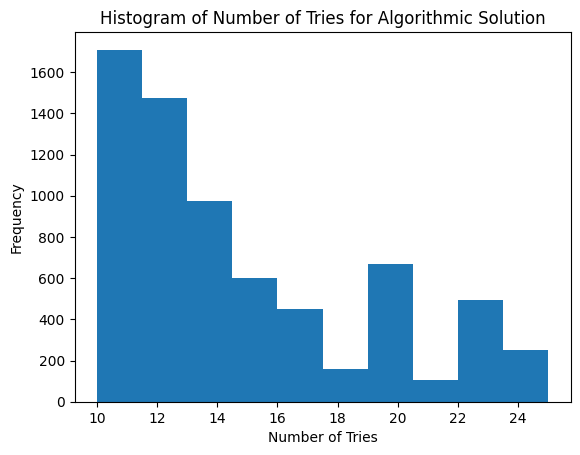

In [796]:
# plot a histogram of the number of tries for the algorithmic solution
import matplotlib.pyplot as plt

plt.hist(merged_df['num_tries_algo'], bins=10)
plt.xlabel('Number of Tries')
plt.ylabel('Frequency')
plt.title('Histogram of Number of Tries for Algorithmic Solution')
plt.show()

In [802]:
merged_df['num_train_batches_optim'].isna().sum()

2583

In [799]:
time = time_budget*1000

In [800]:
merged_df.to_csv(f'interleaved_{model_train}_train_{model_infer}_infer_multi_al.csv', index=False)